In [78]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [81]:
#read in the data, get normalized adjacency (NxN)
%run helpers_preproc.ipynb
mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

type = get_same_type(label_np)
test, train = get_test_train(type)

In [82]:
label_mat = form_label_matrix(label_mat, train)

torch.Size([450, 450])


In [83]:
normed_adjMats_list, node_sigs_list = prep_data(train)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_45354/4163488392.py:70: RuntimeWarning: invalid value encountered in divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])


In [84]:
normed_adjMats = np.stack(normed_adjMats_list)
node_sigs = np.stack(node_sigs_list)

normed_adjMats = torch.tensor(normed_adjMats,requires_grad=False).float()
node_sigs = torch.tensor(node_sigs,requires_grad=False).float()

normed_adjMats = torch.nan_to_num(normed_adjMats,0,0,0)
node_sigs = torch.nan_to_num(node_sigs,0,0,0)

In [85]:
node_sigs

tensor([[[8.0000, 0.0975, 0.0000, 0.5081, 0.5081],
         [5.0000, 0.0975, 0.0000, 0.2521, 0.2521],
         [7.0000, 0.1040, 0.0000, 0.4438, 0.4438],
         ...,
         [6.0000, 0.0804, 0.0000, 0.3440, 0.3440],
         [4.0000, 0.0475, 0.0000, 0.1420, 0.1420],
         [5.0000, 0.0775, 0.0000, 0.2113, 0.2113]],

        [[5.0000, 0.1580, 0.0000, 0.4133, 0.4133],
         [6.0000, 0.2462, 0.0000, 0.7495, 0.7495],
         [4.0000, 0.1513, 0.0000, 0.3373, 0.3373],
         ...,
         [7.0000, 0.1353, 0.0000, 0.5776, 0.5776],
         [5.0000, 0.1206, 0.0000, 0.4141, 0.4141],
         [6.0000, 0.1083, 0.0000, 0.4870, 0.4870]],

        [[7.0000, 0.1930, 0.0000, 0.6834, 0.6834],
         [7.0000, 0.1915, 0.0000, 0.7035, 0.7035],
         [5.0000, 0.1088, 0.0000, 0.3728, 0.3728],
         ...,
         [5.0000, 0.1061, 0.0000, 0.3954, 0.3954],
         [5.0000, 0.1057, 0.0000, 0.3634, 0.3634],
         [5.0000, 0.1498, 0.0000, 0.4610, 0.4610]],

        ...,

        [[4.0000, 0.

In [86]:
class GCN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.f = 5
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.f,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, adjM,node_sigM):
        curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,node_sigM),self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,curr_output),self.weights[i])) #nxc

        return curr_output

In [87]:
class NNN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.input_shape = 2520
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.input_shape,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, x):
        x = torch.flatten(x,1,2)
        torch.matmul(x,self.weights[0])
        curr_output = torch.tanh(torch.matmul(x,self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(curr_output,self.weights[i])) #nxc

        return curr_output

In [88]:
g = GCN([10,10,10,10])
n = NNN([10,10,10,10])
output1 = g.forward(normed_adjMats,node_sigs)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([450, 252, 10])
torch.Size([450, 10])


In [89]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * (label_mat-torch.diag(torch.ones(450)))
    diffType = disMat * (1-label_mat)
    sameTypeMean = torch.sum(sameType) / 12000
    diffTypeMean = torch.sum(diffType) /348000

    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / 12000
    diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / 348000

    #print(disMat)
    return  sameTypeMean - diffTypeMean + 0.2 * (sameTypeStd + diffTypeStd)

In [101]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats,node_sigs))
    loss = lossF(output)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(-1.0423, grad_fn=<AddBackward0>)
tensor(-1.0602, grad_fn=<AddBackward0>)
tensor(-1.0550, grad_fn=<AddBackward0>)
tensor(-1.0605, grad_fn=<AddBackward0>)
tensor(-1.0636, grad_fn=<AddBackward0>)
tensor(-1.0624, grad_fn=<AddBackward0>)
tensor(-1.0629, grad_fn=<AddBackward0>)
tensor(-1.0636, grad_fn=<AddBackward0>)
tensor(-1.0634, grad_fn=<AddBackward0>)
tensor(-1.0640, grad_fn=<AddBackward0>)
tensor(-1.0654, grad_fn=<AddBackward0>)
tensor(-1.0662, grad_fn=<AddBackward0>)
tensor(-1.0651, grad_fn=<AddBackward0>)
tensor(-1.0654, grad_fn=<AddBackward0>)
tensor(-1.0658, grad_fn=<AddBackward0>)
tensor(-1.0662, grad_fn=<AddBackward0>)
tensor(-1.0665, grad_fn=<AddBackward0>)
tensor(-1.0669, grad_fn=<AddBackward0>)
tensor(-1.0666, grad_fn=<AddBackward0>)
tensor(-1.0663, grad_fn=<AddBackward0>)
tensor(-1.0673, grad_fn=<AddBackward0>)
tensor(-1.0677, grad_fn=<AddBackward0>)
tensor(-1.0669, grad_fn=<AddBackward0>)
tensor(-1.0672, grad_fn=<AddBackward0>)
tensor(-1.0672, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [102]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat - torch.diag(torch.ones(450)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)
bins = torch.arange(0,0.1,0.001)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_45354/2044762697.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(450)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_45354/2044762697.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()


(array([0.10888822, 0.07587159, 0.03777707, 0.03238036, 0.03460252,
        0.03301525, 0.02761853, 0.02857089, 0.03396761, 0.02634871,
        0.02365035, 0.0204758 , 0.02031711, 0.01714253, 0.02444398,
        0.01682508, 0.01492035, 0.01269817, 0.01587272, 0.01238072,
        0.01238072, 0.01142836, 0.01174581, 0.00920618, 0.01142836,
        0.00539672, 0.006984  , 0.01047599, 0.006984  , 0.00539672,
        0.006984  , 0.00539672, 0.00412691, 0.00476182, 0.00412691,
        0.00444436, 0.00539672, 0.00126982, 0.00380945, 0.00476182,
        0.00190473, 0.003492  , 0.003492  , 0.00380945, 0.00285709,
        0.00444436, 0.00412691, 0.00730145, 0.00317454, 0.00222218,
        0.00285709, 0.00190473, 0.00222218, 0.00253963, 0.00253963,
        0.00190473, 0.00380945, 0.00571418, 0.00253963, 0.00253963,
        0.00126982, 0.00190473, 0.00063491, 0.00158727, 0.00063491,
        0.00190473, 0.00190473, 0.00190473, 0.        , 0.00031745,
        0.00190473, 0.00285709, 0.00253963, 0.00

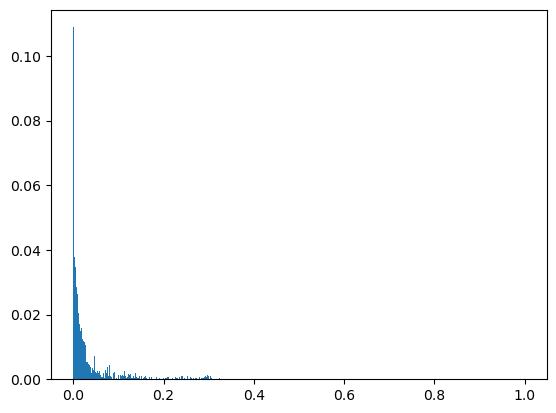

In [103]:
plt.hist(sameComp,bins=np.arange(0,1,0.001),weights=weightsSame,log = False)

(array([0.01961686, 0.01435504, 0.00738697, ..., 0.        , 0.        ,
        0.        ]),
 array([0.000e+00, 1.000e-03, 2.000e-03, ..., 7.997e+00, 7.998e+00,
        7.999e+00]),
 <BarContainer object of 7999 artists>)

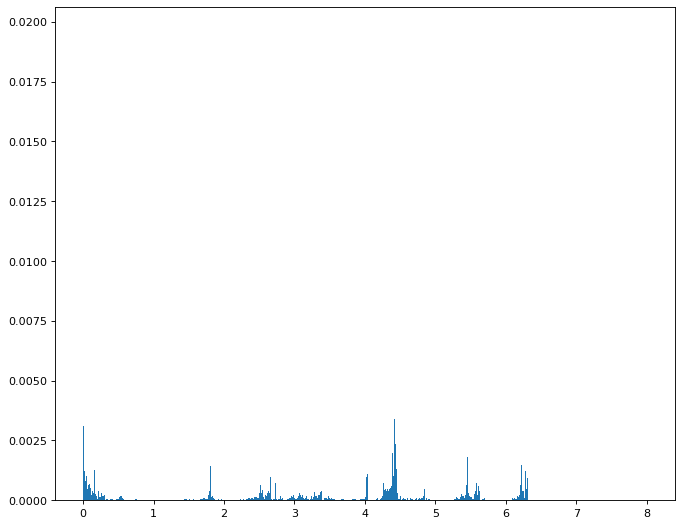

In [104]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
plt.hist(diffComp,bins=np.arange(0,8,0.001),weights=weightsDiff,log = False)

In [105]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [106]:
len(BigDiffIndices)

167560

In [107]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [108]:
for index in BigDiffIndices:
    row, col = divmod(index,600)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [109]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.61986301, 0.64383562, 0.60787671, 0.66438356, 0.60958904,
        0.64383562, 0.51027397, 0.70205479, 0.59589041, 0.66438356,
        0.55136986, 0.66952055, 0.5890411 , 0.48972603, 0.70205479,
        0.67294521, 0.6489726 , 0.59075342, 0.49486301, 0.69349315,
        0.79280822, 0.63184932, 0.59931507, 0.80821918, 0.69178082,
        0.64726027, 0.66438356, 0.625     , 0.64212329, 0.61643836],
       [0.64383562, 0.6609589 , 0.59417808, 0.69349315, 0.60958904,
        0.66952055, 0.51712329, 0.71917808, 0.61815068, 0.67636986,
        0.57020548, 0.67465753, 0.60445205, 0.5       , 0.69006849,
        0.69520548, 0.65753425, 0.59931507, 0.53767123, 0.70034247,
        0.81678082, 0.62671233, 0.63184932, 0.82363014, 0.69691781,
        0.68664384, 0.69006849, 0.63184932, 0.6609589 , 0.61472603],
       [0.60787671, 0.59417808, 0.53767123, 0.625     , 0.54109589,
        0.60273973, 0.43321918, 0.66267123, 0.54452055, 0.59075342,
        0.49657534, 0.59246575, 0.54965753, 0.

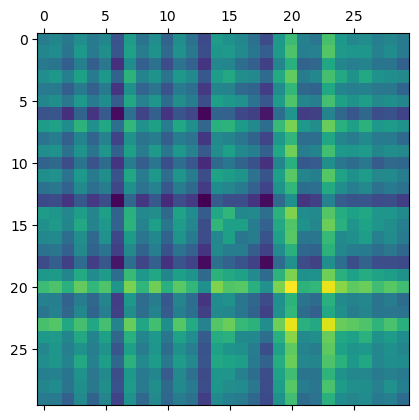

In [110]:
plt.matshow(vizMat)